# Load eCLIP Object

In [1]:
import sys
sys.path.append('/home/hsher/projects/Metadensity')
import metadensity as md
import pandas as pd
import matplotlib.pyplot as plt
md.settings.root_dir = '/home/hsher/seqdata/20200622_gencode_coords_hsher/'
md.settings.transcript_fname = 'gencode.vM25.transcript.gff3'
md.settings.gencode_feature_fname = 'gencode.vM25.combine.sorted.gff3'

In [2]:
md.settings.transcript_fname

'gencode.vM25.transcript.gff3'

In [3]:
from metadensity.metadensity import *

In [4]:
transcript

<BedTool(/home/hsher/seqdata/20200622_gencode_coords_hsher/gencode.vM25.transcript.gff3)>

In [5]:
condition_dict = {'YTHDF2':
                  {'lib': ['m1', 'm2', 'm3'],
                  'fast':['m4', 'm5', 'm6']
                 },
                  'm6A':
                {'lib': ['m7', 'm8', 'm9'],
                  'fast':['m10', 'm11', 'm12']
                 }}
def build_density(eCLIP, name = 'YTHDF2', condition = 'fast'):
    for i, sample in enumerate(condition_dict[name][condition]):
        for seq in ['IP', 'Input']:
            base_dir = '/home/hsher/YTHDF2/bigwigs'
            pos = '{}/zt2_liver_{}_eCLIP.{}_{}.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.{}.bw'.format(
                base_dir, name, sample, seq, 'pos')
            neg = '{}/zt2_liver_{}_eCLIP.{}_{}.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.{}.bw'.format(
                base_dir, name, sample, seq, 'neg')
            print(pos)
            
            #eCLIP.read_densities is a dict
            density = ReadDensity(pos, neg, name = name)
            if seq == 'IP':
                key = 'rep{}'.format(i+1)
                
            if seq == 'Input':
                key = 'ctrl{}'.format(i+1)
            eCLIP.read_densities[key] = density
            
            # names
            eCLIP.name = '{}_{}'.format(name, condition)
            eCLIP.rep_keys = ['rep1', 'rep2', 'rep3']
            
            # peaks
            if seq == 'IP':
                base_dir = '/home/hsher/YTHDF2/raw_beds'
                fname = '{}/zt2_liver_{}_eCLIP.{}_{}.umi.r1.fq.genome-mappedSoSo.rmDupSo.peakClusters.normed.compressed.bed'.format(base_dir, name, sample, seq)
                eCLIP.peaks[key] = BedTool(fname)
    
    # Intersect peaks
    base_dir = '/home/hsher/YTHDF2/intersecting_beds'
    
    fname = '{}/{}_{}_2rep_bed6.bed'.format(base_dir, name, condition)
    eCLIP.idr = BedTool(fname)
    print(fname)
    
    return eCLIP

In [6]:
YTHDF_lib = eCLIP() # YTHFD on control
YTHDF_lib = build_density(YTHDF_lib, name = 'YTHDF2', condition = 'lib')
YTHDF_fast = eCLIP() # YTHDF on fasting
YTHDF_fast = build_density(YTHDF_fast, name = 'YTHDF2', condition = 'fast')

/home/hsher/YTHDF2/bigwigs/zt2_liver_YTHDF2_eCLIP.m1_IP.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.pos.bw
warning no bam file!
/home/hsher/YTHDF2/bigwigs/zt2_liver_YTHDF2_eCLIP.m1_Input.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.pos.bw
warning no bam file!
/home/hsher/YTHDF2/bigwigs/zt2_liver_YTHDF2_eCLIP.m2_IP.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.pos.bw
warning no bam file!
/home/hsher/YTHDF2/bigwigs/zt2_liver_YTHDF2_eCLIP.m2_Input.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.pos.bw
warning no bam file!
/home/hsher/YTHDF2/bigwigs/zt2_liver_YTHDF2_eCLIP.m3_IP.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.pos.bw
warning no bam file!
/home/hsher/YTHDF2/bigwigs/zt2_liver_YTHDF2_eCLIP.m3_Input.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.pos.bw
warning no bam file!
/home/hsher/YTHDF2/intersecting_beds/YTHDF2_lib_2rep_bed6.bed
/home/hsher/YTHDF2/bigwigs/zt2_liver_YTHDF2_eCLIP.m4_IP.umi.r1.fq.genome-mappedSoSo.rmDupSo.norm.pos.bw
warning no bam file!
/home/hsher/YTHDF2/bigwigs/zt2_liver_YTHDF2_eCLIP.m4_I

# Find differentially expressed genes
some genes will be upregulated upon fasting; some genes will be downregulated.
Our question is: What role does YTHDF play in this regulation? Does YTHDF has direct binding to those transcripts? By What mechanism does YTHDF regulate them (suspecting intron retention).

To Answer this question, I will be extracting density from transcripts fitting both conditions:
adjusted **p-value < 0.05**

Normally I would also filter for log FC > 1, but since *there's no transcript staisfying both conditions, I omit this criteria.*



plus a third condition:
3. Containing at least 1 peak with logFC > 2

This ensure that filtered transcripts at least have some binding from YTHDF2. Since from each KD there are many indirect changes, and we don't want those transcripts to mess up with your signal.

In short, the set of transcript will be 
`(differentially expressed ) && (at least some binding)`


## Take a look at the DESeq output!

In [7]:
root_dir =  '/home/hsher/YTHDF2/'
fname = 'DESeq2_all_0.2_genenames.xlsx' 

In [8]:
de = pd.read_excel(root_dir + fname)

In [9]:
de.head()

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,gene_type
0,ENSMUSG00000076555.3,4.171060,5.014446,3.010225,1.665804,NaN,NaN,Igkv4-57-1,IG_V_gene
1,ENSMUSG00000075318.13,6.627721,3.942275,1.586657,2.484643,0.012968,NaN,Scn2a,protein_coding
2,ENSMUSG00000038257.9,6.186182,3.849111,1.450792,2.653109,NaN,NaN,Glra3,protein_coding
3,ENSMUSG00000076614.7,4.309823,3.618688,0.935153,3.869621,0.000109,NaN,Ighg1,IG_C_gene
4,ENSMUSG00000024029.4,8.901666,3.387887,1.650262,2.052939,NaN,NaN,Tff3,protein_coding


In [10]:
sum(de['padj'] < 0.05) # little DE genes

214

In [11]:
de.loc[(de['padj']<0.05) & de['log2FoldChange']>3] # no gene with large enough fold change

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,gene_type


In [12]:
de.loc[(de['padj']<0.05) & de['log2FoldChange']>2]

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,gene_type


In [13]:
de.loc[(de['padj']<0.05) & de['log2FoldChange']>1] # too bad

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name,gene_type


In [23]:
gene_list = de['Unnamed: 0'].str.split('.', expand = True)[0].tolist()
len(transcript.filter(lambda x: x.attrs['gene_id'].split('.')[0] in gene_list))

14635

In [46]:
def get_coord_from_id(gene_id_list):
    ''' given gene id, return coordinates'''
    return transcript.filter(lambda x: x.attrs['gene_id'].split('.')[0] in gene_id_list).saveas()

def get_background_id(gene_id_list):
    ''' given differentially regulated genes, return coord that is not de'''
    return transcript.filter(lambda x: x.attrs['gene_id'].split('.')[0] not in gene_id_list).saveas()

def extract_de_transcripts(eCLIP, de, sample_no = 150, pval_thres = 0.05, logFC_thres = 0):
    ''' extract de transcript and make metadensity based on those transcripts
    will have three group of transcripts, the ones that are up-regulated/downregulated and neither(background)'''
    
    
    de = de.loc[de['padj']<pval_thres]
    up = de.loc[de['log2FoldChange']> logFC_thres] # up regulated genes
    down = de.loc[de['log2FoldChange']< -logFC_thres] # down regulated genes
    
    # find genome coordinate for those genes
    up_list = up['Unnamed: 0'].str.split('.', expand = True)[0].tolist()
    up_coord = get_coord_from_id(up_list)
    
    down_list = down['Unnamed: 0'].str.split('.', expand = True)[0].tolist()
    down_coord = get_coord_from_id(down_list)
    
    back_coord = get_background_id(up_list + down_list)
    
    print('# coords up:{} down:{} back:{}'.format(len(up_coord), len(down_coord), len(back_coord)))
    
    # find those are "directly regulated" by YTHDF2, those with 2-rep peaks
    up_transcript = up_coord.intersect(eCLIP.idr, u = True, s = True).saveas()
    down_transcript = down_coord.intersect(eCLIP.idr, u = True, s = True).saveas()
    back_transcript = back_coord.intersect(eCLIP.idr, u = True, s = True).saveas()
    
    print('# direct regulated up:{} down:{} back:{}'.format(len(up_transcript), len(down_transcript), len(back_transcript)))
    
    
    
    
    all_meta = []
    for bed, group in zip([up_transcript, down_transcript, back_transcript], ['upregualated', 'downregulated', 'background']):
        meta = Metadensity(eCLIP, bed, group, sample_no = sample_no)
        meta.get_density_array()
        meta.get_quantile_metadensity()
        meta.get_density_array(use_quantile = True)
        meta.scale_density_array('max_scalar', quantile = True)
        
        all_meta.append(meta)
                          
    
    return all_meta, back_transcript

In [47]:
ythdf_bygroup, whole_background_lib = extract_de_transcripts(YTHDF_lib, de)

# coords up:115 down:99 back:55010
# direct regulated up:30 down:37 back:4343


In [32]:
from metadensity.plotd import *
color_dict = {'upregualated':'tomato',
         'downregulated':'royalblue', 
         'background':'grey',
             'logFC: (-inf, -2.0]': 'mediumslateblue',
 'logFC: (-2.0, -1.0]':'dodgerblue',
 'logFC: (-1.0, 0.0]': 'lightseagreen',
 'logFC: (0.0, 1.0]': 'gold',
 'logFC: (1.0, 2.0]': 'orange',
 'logFC: (2.0, inf]': 'tomato'}

def plot_mean_density(metas, quantile = False, ymax = 0.003, scaled = False, alpha = 0.6, plot_std = True, stat = 'mean'):
    ''' get a bunch of eCLIPs, plot their mean density'''
    fig, ax_dict = generate_axis(nrows = 1)
    
    
    
    # set ylabel
    
    _ = [ax_dict[key].set_ylabel(stat + ' density') for key in ax_dict.keys() if 'five_utr' in key and 'left' in key]
    _ = [ax_dict[key].set_ylim(ymax = ymax, ymin = 0) for key in ax_dict.keys() if 'five_utr' in key]
    
    for m in metas:
        i=0
        if quantile:
            den_arr = m.qdensity_array
        else:
            den_arr = m.density_array
        if scaled:
            den_arr = m.scaled_density_array
        for feat in featnames:
            for align in ['left', 'right']:
                density_concat = np.concatenate([den_arr[feat,align, r] for r in ['rep1', 'rep2']], axis = 0)
                if stat == 'mean':
                    md = np.nanmean(density_concat, axis = 0)
                if stat == 'median':
                    md = np.nanmedian(density_concat, axis = 0)
                
                std = np.nanstd(density_concat, axis = 0)
                n = den_arr[feat,align, 'rep1'].shape[0] + den_arr[feat,align, 'rep2'].shape[0]
                sem = std/np.sqrt(n)
                
                ax = ax_dict[feat, align, 'rep1']
                
                ax.plot(md, label = m.name, color = color_dict[m.name])
                
                if plot_std:
                    ax.fill_between(np.arange(len(md)), md-sem, md+sem, label = m.name, alpha = alpha, color = color_dict[m.name])
                
                
                    
                i+= 1
    plt.legend(bbox_to_anchor = (1.5, 0.5))
    
    if quantile:
        t = 'Quantile Metadensity'
    elif scaled:
        t = 'Scaled Metadensity'
    else:
        t = 'Normalized Metadensity'
    title = '{}:{}; '.format(m.eCLIP.name, t)
    plt.suptitle(title)

## Plotting transcript on `YTHDF_lib` eCLIP signal.

blue is the transcripts downregulated upon fasting.
red is the transcript upregulated upon fasting.
background are other transcripts.
Looks like there isn't much difference


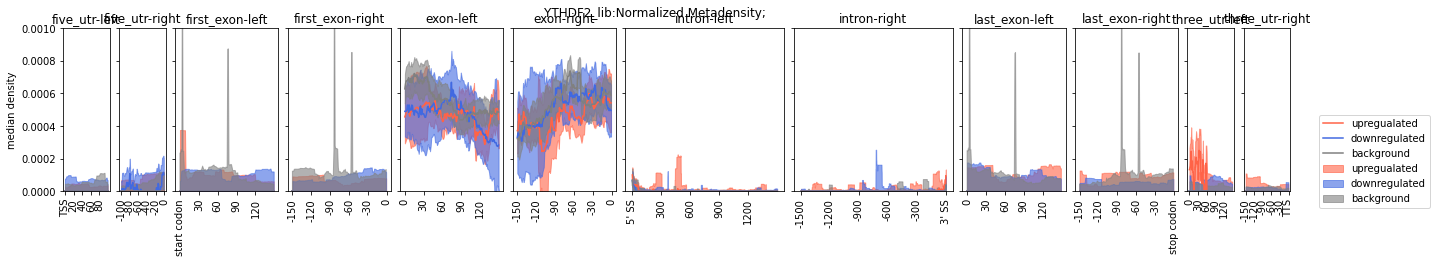

In [33]:
plot_mean_density(ythdf_bygroup, plot_std = True, stat = 'median', ymax = 0.001)
# LIN28 protein binding mildly stabilized target mRNAs and increased protein abundance.
# it is driven by some large values to get mean big; the median is red higher

## Plotting transcript on `YTHDF_fast` signal.

blue is the transcripts downregulated upon fasting.
red is the transcript upregulated upon fasting.
background are other transcripts.
looks like the **upregulated genes** has more binding.


In [48]:
ythdf_fast_bygroup, whole_background_fast = extract_de_transcripts(YTHDF_fast, de)

# coords up:115 down:99 back:55010
# direct regulated up:42 down:48 back:5165


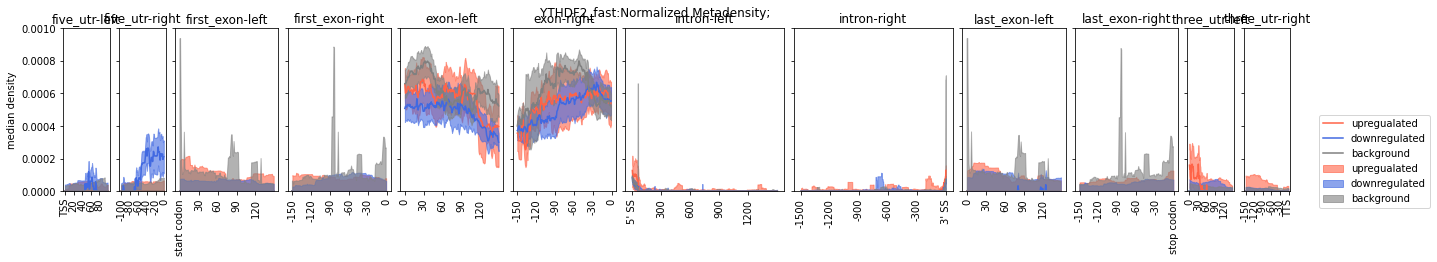

In [35]:
plot_mean_density(ythdf_fast_bygroup, plot_std = True, stat = 'median', ymax = 0.001)
# LIN28 protein binding mildly stabilized target mRNAs and increased protein abundance.
# it is driven by some large values to get mean big; the median is red higher

# Bootstrapping for statistical significance

Now I am going to create a null distribution using background transcripts: `those that are NOT up or down regulated, but bound by YTHDF`.

The idea of bootstrapping is to randomly sample a subset of all backgrounds (I'll use `n=50`), compute the median, for many many times. After that, we can know how the median of background is distributed (as the null). Then we examine whether the up/down regulated gene's median density is significantly different from background!

In [ ]:
def bootstrap_null(eCLIP, whole_background, name = 'whole_background'):
    
    # fetch the whole background metadensity
    meta = Metadensity(eCLIP, whole_background, name, sample_no = len(whole_background))
    meta.get_density_array()

In [ ]:
meta = Metadensity(YTHDF_fast, whole_background_fast, 'whole_background', sample_no = len(whole_background_fast))
meta.get_density_array()

In [ ]:
meta.density_array['five_utr', 'left', 'rep1'].shape

In [ ]:
len(whole_background_fast)